# Red Inicial


## Imports


In [1]:
from __future__ import annotations

from itertools import product
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Acciones
from custom_env.router_env import RouterEnv
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

Cargado a las 2025-03-03 12:27:36.085718


In [2]:
name = "Example"
tmp_path = "./train_log/"
env_id = "RouterEnv-v0"

progress_bar = True
if progress_bar == True:
    import rich
    import tqdm

## Clases y Funciones


In [3]:

"""

class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")
    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----
    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)
    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)


gen = DOS_Packet_Generator(step_dur=1e-6,seed=1)




print(len(gen.generate_packets()))

"""

'\n\nclass PacketAttack(Enum):\n    @staticmethod\n    def new_set(description, weight, class_ref):\n        return {\n            "Description": description,\n            "weight": weight,\n            "class": class_ref\n        }\n\n    @staticmethod\n    def not_implemented():\n        raise NotImplementedError(f"Class not implemented")\n    @classmethod\n    @cache\n    def weights(cls):\n        attack_weights = []\n        for attack in PacketAttack:\n            attack_weights.append(attack.value["weight"])\n        return np.array(attack_weights)\n\n    # ----ENUM VALUES----\n    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)\n    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)\n\n\ngen = DOS_Packet_Generator(step_dur=1e-6,seed=1)\n\n\n\n\nprint(len(gen.generate_packets()))\n\n'

In [4]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun

## Entrenamiento


In [5]:

seed = None
env: RouterEnv = make(env_id, seed=seed)
# env = RouterEnv(seed=None)
check_env(env)

new_logger: Logger = configure(tmp_path, ["stdout", "csv"])
env = Monitor(env, tmp_path)


model: PPO = PPO("MultiInputPolicy", env,
                 verbose=True)


"""
eval_callback = EvalCallback(
    env,  # Entorno de evaluación
    best_model_save_path="./logs/best_model",  # Ruta para guardar el mejor modelo
    log_path="./logs",  # Ruta para guardar estadísticas
    eval_freq=10000,  # Frecuencia de evaluación (en pasos)
    deterministic=True,
    render=False,
)
, callback=eval_callback
"""
"""
ep_info = a.ep_info_buffer
print(a.ep_info_buffer)
if ep_info is not None and len(ep_info) > 0:
    rew=ep_info[0]["r"]
    print(rew)
    saved= PPO.load("Example")
    print(ep_info.pop())
"""


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5//0.5),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Logging to ./train_log/
Using cpu device
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -1.1e+03 |
| time/              |          |
|    fps             | 480      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -968         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0062167267 |
|    clip_fraction        | 0.126        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explained_variance   | -0.00226     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.7e+03      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00982     |
|    value_loss           | 3.15e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 436         |
|    iterations           | 3           |
|    time_elapsed         | 14          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.005422708 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.675      |
|    explained_variance   | 0.0212      |
|    learning_rate        | 0.0003      |
|    loss                 | 416         |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00824    |
|    value_loss           | 1.32e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.09e+03    |
| time/                   |              |
|    fps                  | 438          |
|    iterations           | 4            |
|    time_elapsed         | 18           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0031092125 |
|    clip_fraction        | 0.0282       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.66        |
|    explained_variance   | 0.00592      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.45e+03     |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00251     |
|    value_loss           | 6.48e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.3e+03      |
| time/                   |               |
|    fps                  | 441           |
|    iterations           | 5             |
|    time_elapsed         | 23            |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 0.00052445155 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.651        |
|    explained_variance   | 0.00148       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+04      |
|    n_updates            | 40            |
|    policy_gradient_loss | 2.18e-05      |
|    value_loss           | 1.76e+04      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.1e+03     |
| time/                   |              |
|    fps                  | 445          |
|    iterations           | 6            |
|    time_elapsed         | 27           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0014591191 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.646       |
|    explained_variance   | 0.000362     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.43e+05     |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 4.61e+05     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.88e+03    |
| time/                   |              |
|    fps                  | 450          |
|    iterations           | 7            |
|    time_elapsed         | 31           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0046706526 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.645       |
|    explained_variance   | 0.00144      |
|    learning_rate        | 0.0003       |
|    loss                 | 6.69e+03     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.000797    |
|    value_loss           | 9.17e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -1.97e+03   |
| time/                   |             |
|    fps                  | 452         |
|    iterations           | 8           |
|    time_elapsed         | 36          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012096252 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.59       |
|    explained_variance   | 0.00138     |
|    learning_rate        | 0.0003      |
|    loss                 | 174         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 517         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.78e+03    |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 9            |
|    time_elapsed         | 40           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0021423935 |
|    clip_fraction        | 0.0331       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.611       |
|    explained_variance   | 0.000122     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.65e+04     |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00213     |
|    value_loss           | 7.11e+04     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -1.63e+03   |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 10          |
|    time_elapsed         | 45          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.009644653 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.543      |
|    explained_variance   | 0.00075     |
|    learning_rate        | 0.0003      |
|    loss                 | 226         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 465         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.75e+03    |
| time/                   |              |
|    fps                  | 454          |
|    iterations           | 11           |
|    time_elapsed         | 49           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0076390314 |
|    clip_fraction        | 0.146        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.487       |
|    explained_variance   | 0.000398     |
|    learning_rate        | 0.0003       |
|    loss                 | 80.3         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.0144      |
|    value_loss           | 252          |
------------------------------------------


--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 400            |
|    ep_rew_mean          | -1.7e+03       |
| time/                   |                |
|    fps                  | 460            |
|    iterations           | 12             |
|    time_elapsed         | 53             |
|    total_timesteps      | 24576          |
| train/                  |                |
|    approx_kl            | 0.000119215314 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.493         |
|    explained_variance   | 0.00179        |
|    learning_rate        | 0.0003         |
|    loss                 | 9.88e+04       |
|    n_updates            | 110            |
|    policy_gradient_loss | -0.000605      |
|    value_loss           | 9.63e+04       |
--------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.6e+03     |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 13           |
|    time_elapsed         | 58           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0001116434 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.495       |
|    explained_variance   | 0.00627      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.53e+04     |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000181    |
|    value_loss           | 2.37e+04     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.55e+03     |
| time/                   |               |
|    fps                  | 455           |
|    iterations           | 14            |
|    time_elapsed         | 63            |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 5.6043034e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.497        |
|    explained_variance   | 0.00644       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.01e+05      |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.000432     |
|    value_loss           | 2.4e+05       |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.39e+03    |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 15           |
|    time_elapsed         | 67           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 7.120834e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.49        |
|    explained_variance   | 0.00968      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.23e+05     |
|    n_updates            | 140          |
|    policy_gradient_loss | -5.28e-05    |
|    value_loss           | 9.49e+05     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -2.4e+03    |
| time/                   |             |
|    fps                  | 460         |
|    iterations           | 16          |
|    time_elapsed         | 71          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.014155437 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.43       |
|    explained_variance   | -0.0671     |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 341         |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.26e+03     |
| time/                   |               |
|    fps                  | 462           |
|    iterations           | 17            |
|    time_elapsed         | 75            |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | 0.00016452954 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.42         |
|    explained_variance   | 0.00762       |
|    learning_rate        | 0.0003        |
|    loss                 | 3.78e+04      |
|    n_updates            | 160           |
|    policy_gradient_loss | -0.000696     |
|    value_loss           | 1.07e+05      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.49e+03     |
| time/                   |               |
|    fps                  | 467           |
|    iterations           | 19            |
|    time_elapsed         | 83            |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 0.00023532927 |
|    clip_fraction        | 0.000635      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.422        |
|    explained_variance   | 0.0476        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.68e+04      |
|    n_updates            | 180           |
|    policy_gradient_loss | -0.000718     |
|    value_loss           | 1.04e+05      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.55e+03     |
| time/                   |               |
|    fps                  | 469           |
|    iterations           | 20            |
|    time_elapsed         | 87            |
|    total_timesteps      | 40960         |
| train/                  |               |
|    approx_kl            | 2.8955983e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.425        |
|    explained_variance   | 0.0284        |
|    learning_rate        | 0.0003        |
|    loss                 | 3.4e+05       |
|    n_updates            | 190           |
|    policy_gradient_loss | -6.32e-06     |
|    value_loss           | 4.35e+05      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.88e+03    |
| time/                   |              |
|    fps                  | 470          |
|    iterations           | 21           |
|    time_elapsed         | 91           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 9.634864e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.424       |
|    explained_variance   | 0.0598       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.76e+04     |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.000116    |
|    value_loss           | 1.13e+05     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.87e+03     |
| time/                   |               |
|    fps                  | 471           |
|    iterations           | 22            |
|    time_elapsed         | 95            |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 1.3559969e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.409        |
|    explained_variance   | 0.0452        |
|    learning_rate        | 0.0003        |
|    loss                 | 2.79e+05      |
|    n_updates            | 210           |
|    policy_gradient_loss | -3.53e-05     |
|    value_loss           | 5.4e+05       |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -2.83e+03     |
| time/                   |               |
|    fps                  | 473           |
|    iterations           | 23            |
|    time_elapsed         | 99            |
|    total_timesteps      | 47104         |
| train/                  |               |
|    approx_kl            | 0.00028559894 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.421        |
|    explained_variance   | 0.247         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.74e+03      |
|    n_updates            | 220           |
|    policy_gradient_loss | 0.000102      |
|    value_loss           | 6.56e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -3.13e+03   |
| time/                   |             |
|    fps                  | 475         |
|    iterations           | 24          |
|    time_elapsed         | 103         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.005128751 |
|    clip_fraction        | 0.0041      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.421      |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.41e+03    |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00617    |
|    value_loss           | 3.73e+03    |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -3.11e+03     |
| time/                   |               |
|    fps                  | 477           |
|    iterations           | 25            |
|    time_elapsed         | 107           |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 5.7494748e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.456        |
|    explained_variance   | 0.0614        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.94e+05      |
|    n_updates            | 240           |
|    policy_gradient_loss | -6.7e-05      |
|    value_loss           | 4.33e+05      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -3.27e+03   |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 26          |
|    time_elapsed         | 111         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.001062412 |
|    clip_fraction        | 0.00527     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.464      |
|    explained_variance   | 0.0433      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.32e+05    |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0011     |
|    value_loss           | 5.06e+05    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -3.17e+03    |
| time/                   |              |
|    fps                  | 479          |
|    iterations           | 27           |
|    time_elapsed         | 115          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0016183221 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.456       |
|    explained_variance   | 0.0673       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+05      |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00103     |
|    value_loss           | 1.94e+05     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -3.14e+03    |
| time/                   |              |
|    fps                  | 480          |
|    iterations           | 28           |
|    time_elapsed         | 119          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0058069453 |
|    clip_fraction        | 0.0273       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.415       |
|    explained_variance   | 0.398        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.91e+03     |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00491     |
|    value_loss           | 2.46e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -3.17e+03    |
| time/                   |              |
|    fps                  | 481          |
|    iterations           | 29           |
|    time_elapsed         | 123          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0006539559 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.396       |
|    explained_variance   | 0.485        |
|    learning_rate        | 0.0003       |
|    loss                 | 612          |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 1.19e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -3.16e+03     |
| time/                   |               |
|    fps                  | 482           |
|    iterations           | 30            |
|    time_elapsed         | 127           |
|    total_timesteps      | 61440         |
| train/                  |               |
|    approx_kl            | 0.00029040978 |
|    clip_fraction        | 0.00781       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.412        |
|    explained_variance   | 0.271         |
|    learning_rate        | 0.0003        |
|    loss                 | 4.44e+03      |
|    n_updates            | 290           |
|    policy_gradient_loss | -0.00024      |
|    value_loss           | 1.42e+04      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -3.02e+03    |
| time/                   |              |
|    fps                  | 480          |
|    iterations           | 31           |
|    time_elapsed         | 132          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0037689728 |
|    clip_fraction        | 0.0532       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.344       |
|    explained_variance   | 0.617        |
|    learning_rate        | 0.0003       |
|    loss                 | 278          |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00549     |
|    value_loss           | 557          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -3.04e+03    |
| time/                   |              |
|    fps                  | 479          |
|    iterations           | 32           |
|    time_elapsed         | 136          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0015509938 |
|    clip_fraction        | 0.00459      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.344       |
|    explained_variance   | 0.564        |
|    learning_rate        | 0.0003       |
|    loss                 | 587          |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 981          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.78e+03    |
| time/                   |              |
|    fps                  | 478          |
|    iterations           | 33           |
|    time_elapsed         | 141          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0018552523 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.373       |
|    explained_variance   | 0.265        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.8e+04      |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.00371     |
|    value_loss           | 2.96e+04     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | -2.68e+03  |
| time/                   |            |
|    fps                  | 476        |
|    iterations           | 34         |
|    time_elapsed         | 145        |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.00491513 |
|    clip_fraction        | 0.0174     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.421     |
|    explained_variance   | 0.291      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.96e+04   |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.00155   |
|    value_loss           | 3.49e+04   |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.67e+03    |
| time/                   |              |
|    fps                  | 476          |
|    iterations           | 35           |
|    time_elapsed         | 150          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0057782438 |
|    clip_fraction        | 0.0476       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.482       |
|    explained_variance   | 0.152        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.57e+04     |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.0068      |
|    value_loss           | 1.5e+05      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.59e+03    |
| time/                   |              |
|    fps                  | 475          |
|    iterations           | 36           |
|    time_elapsed         | 155          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0029278854 |
|    clip_fraction        | 0.0316       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.301       |
|    explained_variance   | 0.509        |
|    learning_rate        | 0.0003       |
|    loss                 | 582          |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00377     |
|    value_loss           | 946          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.75e+03    |
| time/                   |              |
|    fps                  | 475          |
|    iterations           | 37           |
|    time_elapsed         | 159          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0035989368 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.39        |
|    explained_variance   | 0.354        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.01e+03     |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00495     |
|    value_loss           | 2.06e+04     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.34e+03    |
| time/                   |              |
|    fps                  | 471          |
|    iterations           | 38           |
|    time_elapsed         | 165          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0022885888 |
|    clip_fraction        | 0.0119       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.37        |
|    explained_variance   | 0.208        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.11e+04     |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00319     |
|    value_loss           | 8.95e+04     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.34e+03    |
| time/                   |              |
|    fps                  | 469          |
|    iterations           | 39           |
|    time_elapsed         | 170          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0035237074 |
|    clip_fraction        | 0.0313       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.529        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.25e+03     |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00508     |
|    value_loss           | 5.35e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -2.19e+03    |
| time/                   |              |
|    fps                  | 468          |
|    iterations           | 40           |
|    time_elapsed         | 174          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0020303132 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.275       |
|    explained_variance   | 0.606        |
|    learning_rate        | 0.0003       |
|    loss                 | 400          |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 1.07e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.84e+03    |
| time/                   |              |
|    fps                  | 467          |
|    iterations           | 41           |
|    time_elapsed         | 179          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0010682843 |
|    clip_fraction        | 0.0122       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.276       |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.0003       |
|    loss                 | 467          |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.00227     |
|    value_loss           | 809          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.94e+03    |
| time/                   |              |
|    fps                  | 465          |
|    iterations           | 42           |
|    time_elapsed         | 184          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0022238754 |
|    clip_fraction        | 0.00288      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.345       |
|    explained_variance   | 0.559        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.07e+03     |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.000783    |
|    value_loss           | 5.03e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -1.93e+03   |
| time/                   |             |
|    fps                  | 465         |
|    iterations           | 43          |
|    time_elapsed         | 189         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.003362836 |
|    clip_fraction        | 0.0268      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.349      |
|    explained_variance   | 0.328       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37e+04    |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00737    |
|    value_loss           | 5.07e+04    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -1.6e+03    |
| time/                   |             |
|    fps                  | 463         |
|    iterations           | 44          |
|    time_elapsed         | 194         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.001803851 |
|    clip_fraction        | 0.0209      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.623       |
|    learning_rate        | 0.0003      |
|    loss                 | 583         |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0015     |
|    value_loss           | 768         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.27e+03    |
| time/                   |              |
|    fps                  | 463          |
|    iterations           | 45           |
|    time_elapsed         | 198          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0024888874 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.258       |
|    explained_variance   | 0.639        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.95e+03     |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00295     |
|    value_loss           | 3.76e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -1.12e+03     |
| time/                   |               |
|    fps                  | 462           |
|    iterations           | 46            |
|    time_elapsed         | 203           |
|    total_timesteps      | 94208         |
| train/                  |               |
|    approx_kl            | 0.00011516074 |
|    clip_fraction        | 0.00273       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.236        |
|    explained_variance   | 0.767         |
|    learning_rate        | 0.0003        |
|    loss                 | 552           |
|    n_updates            | 450           |
|    policy_gradient_loss | 8.29e-05      |
|    value_loss           | 1.12e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.13e+03    |
| time/                   |              |
|    fps                  | 462          |
|    iterations           | 47           |
|    time_elapsed         | 207          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0027617333 |
|    clip_fraction        | 0.0278       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | 0.563        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.19e+03     |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00283     |
|    value_loss           | 8.35e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.12e+03    |
| time/                   |              |
|    fps                  | 461          |
|    iterations           | 48           |
|    time_elapsed         | 212          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0007855549 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.218       |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 458          |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000992    |
|    value_loss           | 1.81e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.07e+03    |
| time/                   |              |
|    fps                  | 461          |
|    iterations           | 49           |
|    time_elapsed         | 217          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0018032311 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.274       |
|    explained_variance   | 0.705        |
|    learning_rate        | 0.0003       |
|    loss                 | 563          |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 1.16e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.07e+03    |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 50           |
|    time_elapsed         | 222          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0015040843 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.661        |
|    learning_rate        | 0.0003       |
|    loss                 | 438          |
|    n_updates            | 490          |
|    policy_gradient_loss | -0.000797    |
|    value_loss           | 646          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -1.07e+03    |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 51           |
|    time_elapsed         | 226          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0027834438 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.284       |
|    explained_variance   | 0.593        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.42e+03     |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00293     |
|    value_loss           | 2.69e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -887         |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 52           |
|    time_elapsed         | 231          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0028134002 |
|    clip_fraction        | 0.0366       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 0.569        |
|    learning_rate        | 0.0003       |
|    loss                 | 286          |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.00132     |
|    value_loss           | 582          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -742         |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 53           |
|    time_elapsed         | 235          |
|    total_timesteps      | 108544       |
| train/                  |              |
|    approx_kl            | 0.0005710819 |
|    clip_fraction        | 0.00439      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.0003       |
|    loss                 | 667          |
|    n_updates            | 520          |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 1.49e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -609          |
| time/                   |               |
|    fps                  | 460           |
|    iterations           | 54            |
|    time_elapsed         | 240           |
|    total_timesteps      | 110592        |
| train/                  |               |
|    approx_kl            | 0.00046214918 |
|    clip_fraction        | 0.00898       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.167        |
|    explained_variance   | 0.719         |
|    learning_rate        | 0.0003        |
|    loss                 | 857           |
|    n_updates            | 530           |
|    policy_gradient_loss | -0.00123      |
|    value_loss           | 1.84e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -609         |
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 55           |
|    time_elapsed         | 244          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0028972095 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.617        |
|    learning_rate        | 0.0003       |
|    loss                 | 354          |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00132     |
|    value_loss           | 975          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -404          |
| time/                   |               |
|    fps                  | 460           |
|    iterations           | 56            |
|    time_elapsed         | 249           |
|    total_timesteps      | 114688        |
| train/                  |               |
|    approx_kl            | 0.00083289563 |
|    clip_fraction        | 0.0176        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.173        |
|    explained_variance   | 0.738         |
|    learning_rate        | 0.0003        |
|    loss                 | 329           |
|    n_updates            | 550           |
|    policy_gradient_loss | -0.00116      |
|    value_loss           | 717           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -372         |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 57           |
|    time_elapsed         | 253          |
|    total_timesteps      | 116736       |
| train/                  |              |
|    approx_kl            | 0.0011508394 |
|    clip_fraction        | 0.0063       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.694        |
|    learning_rate        | 0.0003       |
|    loss                 | 970          |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.000776    |
|    value_loss           | 2.05e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -368         |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 58           |
|    time_elapsed         | 258          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0014788946 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.8          |
|    learning_rate        | 0.0003       |
|    loss                 | 231          |
|    n_updates            | 570          |
|    policy_gradient_loss | -5.92e-05    |
|    value_loss           | 470          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -381         |
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 59           |
|    time_elapsed         | 262          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0005805651 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.152       |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.0003       |
|    loss                 | 469          |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.000794    |
|    value_loss           | 1.01e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -379         |
| time/                   |              |
|    fps                  | 460          |
|    iterations           | 60           |
|    time_elapsed         | 267          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0010226588 |
|    clip_fraction        | 0.0218       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.725        |
|    learning_rate        | 0.0003       |
|    loss                 | 442          |
|    n_updates            | 590          |
|    policy_gradient_loss | -0.0018      |
|    value_loss           | 1.12e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -342         |
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 61           |
|    time_elapsed         | 271          |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0003824322 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.15        |
|    explained_variance   | 0.663        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.07e+03     |
|    n_updates            | 600          |
|    policy_gradient_loss | 4.32e-05     |
|    value_loss           | 1.63e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -227         |
| time/                   |              |
|    fps                  | 459          |
|    iterations           | 62           |
|    time_elapsed         | 276          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0014110894 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.639        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.7e+03      |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00172     |
|    value_loss           | 2.57e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -227         |
| time/                   |              |
|    fps                  | 458          |
|    iterations           | 63           |
|    time_elapsed         | 281          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 0.0015190092 |
|    clip_fraction        | 0.0285       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.123       |
|    explained_variance   | 0.544        |
|    learning_rate        | 0.0003       |
|    loss                 | 277          |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.00182     |
|    value_loss           | 666          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -205          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 64            |
|    time_elapsed         | 287           |
|    total_timesteps      | 131072        |
| train/                  |               |
|    approx_kl            | 0.00091075926 |
|    clip_fraction        | 0.0192        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.123        |
|    explained_variance   | 0.818         |
|    learning_rate        | 0.0003        |
|    loss                 | 282           |
|    n_updates            | 630           |
|    policy_gradient_loss | -0.000486     |
|    value_loss           | 485           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -180         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 65           |
|    time_elapsed         | 291          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0019503969 |
|    clip_fraction        | 0.0308       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.0003       |
|    loss                 | 540          |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00245     |
|    value_loss           | 712          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -168         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 66           |
|    time_elapsed         | 296          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0013099132 |
|    clip_fraction        | 0.031        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.0003       |
|    loss                 | 445          |
|    n_updates            | 650          |
|    policy_gradient_loss | -0.00154     |
|    value_loss           | 1.12e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -176         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 67           |
|    time_elapsed         | 300          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0037439447 |
|    clip_fraction        | 0.0181       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.702        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.41e+03     |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.00167     |
|    value_loss           | 2.19e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -238         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 68           |
|    time_elapsed         | 305          |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0019724108 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.745        |
|    learning_rate        | 0.0003       |
|    loss                 | 724          |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00256     |
|    value_loss           | 2.4e+03      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -242         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 69           |
|    time_elapsed         | 310          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0009260864 |
|    clip_fraction        | 0.011        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.46e+03     |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.00252     |
|    value_loss           | 9.64e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -251         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 70           |
|    time_elapsed         | 314          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0007605516 |
|    clip_fraction        | 0.00825      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.149       |
|    explained_variance   | 0.699        |
|    learning_rate        | 0.0003       |
|    loss                 | 577          |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.000479    |
|    value_loss           | 1.39e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -244          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 71            |
|    time_elapsed         | 318           |
|    total_timesteps      | 145408        |
| train/                  |               |
|    approx_kl            | 0.00020202943 |
|    clip_fraction        | 0.004         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.121        |
|    explained_variance   | 0.743         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.01e+03      |
|    n_updates            | 700           |
|    policy_gradient_loss | -0.000551     |
|    value_loss           | 3.79e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -249         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 72           |
|    time_elapsed         | 322          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0033476737 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.071       |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.0003       |
|    loss                 | 272          |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.000497    |
|    value_loss           | 573          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -224          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 73            |
|    time_elapsed         | 327           |
|    total_timesteps      | 149504        |
| train/                  |               |
|    approx_kl            | 0.00065446924 |
|    clip_fraction        | 0.00259       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.119        |
|    explained_variance   | 0.735         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+03      |
|    n_updates            | 720           |
|    policy_gradient_loss | -0.000456     |
|    value_loss           | 1.94e+03      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -231          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 74            |
|    time_elapsed         | 331           |
|    total_timesteps      | 151552        |
| train/                  |               |
|    approx_kl            | 0.00035788055 |
|    clip_fraction        | 0.00532       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0971       |
|    explained_variance   | 0.692         |
|    learning_rate        | 0.0003        |
|    loss                 | 495           |
|    n_updates            | 730           |
|    policy_gradient_loss | 0.000702      |
|    value_loss           | 769           |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -247          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 75            |
|    time_elapsed         | 336           |
|    total_timesteps      | 153600        |
| train/                  |               |
|    approx_kl            | 0.00058263546 |
|    clip_fraction        | 0.00625       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.128        |
|    explained_variance   | 0.702         |
|    learning_rate        | 0.0003        |
|    loss                 | 864           |
|    n_updates            | 740           |
|    policy_gradient_loss | -0.000324     |
|    value_loss           | 1.98e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -323        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 76          |
|    time_elapsed         | 340         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.000406637 |
|    clip_fraction        | 0.00435     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.101      |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.0003      |
|    loss                 | 1.53e+03    |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.000583   |
|    value_loss           | 2.31e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -349         |
| time/                   |              |
|    fps                  | 457          |
|    iterations           | 77           |
|    time_elapsed         | 345          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0009387928 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.136       |
|    explained_variance   | 0.686        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.75e+03     |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 1e+04        |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -367         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 78           |
|    time_elapsed         | 349          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0009792931 |
|    clip_fraction        | 0.00732      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.135       |
|    explained_variance   | 0.673        |
|    learning_rate        | 0.0003       |
|    loss                 | 988          |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.000763    |
|    value_loss           | 2.88e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -401          |
| time/                   |               |
|    fps                  | 457           |
|    iterations           | 79            |
|    time_elapsed         | 353           |
|    total_timesteps      | 161792        |
| train/                  |               |
|    approx_kl            | 0.00029763358 |
|    clip_fraction        | 0.0117        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.115        |
|    explained_variance   | 0.74          |
|    learning_rate        | 0.0003        |
|    loss                 | 1.61e+03      |
|    n_updates            | 780           |
|    policy_gradient_loss | -0.00175      |
|    value_loss           | 3.45e+03      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -393          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 80            |
|    time_elapsed         | 358           |
|    total_timesteps      | 163840        |
| train/                  |               |
|    approx_kl            | 5.0623596e-05 |
|    clip_fraction        | 0.00146       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.164        |
|    explained_variance   | 0.645         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.24e+03      |
|    n_updates            | 790           |
|    policy_gradient_loss | 0.000249      |
|    value_loss           | 3.78e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -385         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 81           |
|    time_elapsed         | 363          |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0037185233 |
|    clip_fraction        | 0.00986      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0842      |
|    explained_variance   | 0.747        |
|    learning_rate        | 0.0003       |
|    loss                 | 662          |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.000747    |
|    value_loss           | 1.16e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -400        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 82          |
|    time_elapsed         | 367         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.011575891 |
|    clip_fraction        | 0.0409      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0949     |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.0003      |
|    loss                 | 661         |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00375    |
|    value_loss           | 1.34e+03    |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -397          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 83            |
|    time_elapsed         | 372           |
|    total_timesteps      | 169984        |
| train/                  |               |
|    approx_kl            | 0.00026719802 |
|    clip_fraction        | 0.00747       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.1          |
|    explained_variance   | 0.735         |
|    learning_rate        | 0.0003        |
|    loss                 | 806           |
|    n_updates            | 820           |
|    policy_gradient_loss | -0.000651     |
|    value_loss           | 1.92e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -401         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 84           |
|    time_elapsed         | 377          |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0018982468 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0884      |
|    explained_variance   | 0.618        |
|    learning_rate        | 0.0003       |
|    loss                 | 562          |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.000281    |
|    value_loss           | 917          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -385          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 85            |
|    time_elapsed         | 381           |
|    total_timesteps      | 174080        |
| train/                  |               |
|    approx_kl            | 0.00041461573 |
|    clip_fraction        | 0.00835       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.108        |
|    explained_variance   | 0.709         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.05e+03      |
|    n_updates            | 840           |
|    policy_gradient_loss | -0.00182      |
|    value_loss           | 2.13e+03      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -379         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 86           |
|    time_elapsed         | 385          |
|    total_timesteps      | 176128       |
| train/                  |              |
|    approx_kl            | 0.0002242297 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0732      |
|    explained_variance   | 0.723        |
|    learning_rate        | 0.0003       |
|    loss                 | 333          |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.000159    |
|    value_loss           | 721          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -317          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 87            |
|    time_elapsed         | 390           |
|    total_timesteps      | 178176        |
| train/                  |               |
|    approx_kl            | 0.00047876363 |
|    clip_fraction        | 0.00454       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.149        |
|    explained_variance   | 0.694         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.09e+03      |
|    n_updates            | 860           |
|    policy_gradient_loss | 0.00063       |
|    value_loss           | 1.63e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -294        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 88          |
|    time_elapsed         | 394         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.001271215 |
|    clip_fraction        | 0.0248      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.098      |
|    explained_variance   | 0.76        |
|    learning_rate        | 0.0003      |
|    loss                 | 292         |
|    n_updates            | 870         |
|    policy_gradient_loss | -0.00315    |
|    value_loss           | 734         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -322         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 89           |
|    time_elapsed         | 399          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0009829229 |
|    clip_fraction        | 0.00942      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.122       |
|    explained_variance   | 0.708        |
|    learning_rate        | 0.0003       |
|    loss                 | 508          |
|    n_updates            | 880          |
|    policy_gradient_loss | -9.66e-05    |
|    value_loss           | 1.36e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -307         |
| time/                   |              |
|    fps                  | 455          |
|    iterations           | 90           |
|    time_elapsed         | 404          |
|    total_timesteps      | 184320       |
| train/                  |              |
|    approx_kl            | 0.0007059029 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.172       |
|    explained_variance   | 0.663        |
|    learning_rate        | 0.0003       |
|    loss                 | 973          |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.000773    |
|    value_loss           | 2.36e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -311         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 91           |
|    time_elapsed         | 408          |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0005088964 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.756        |
|    learning_rate        | 0.0003       |
|    loss                 | 421          |
|    n_updates            | 900          |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 999          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -347          |
| time/                   |               |
|    fps                  | 455           |
|    iterations           | 92            |
|    time_elapsed         | 413           |
|    total_timesteps      | 188416        |
| train/                  |               |
|    approx_kl            | 0.00083788665 |
|    clip_fraction        | 0.00869       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.15         |
|    explained_variance   | 0.774         |
|    learning_rate        | 0.0003        |
|    loss                 | 794           |
|    n_updates            | 910           |
|    policy_gradient_loss | -4.4e-05      |
|    value_loss           | 1.44e+03      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -361          |
| time/                   |               |
|    fps                  | 455           |
|    iterations           | 93            |
|    time_elapsed         | 417           |
|    total_timesteps      | 190464        |
| train/                  |               |
|    approx_kl            | 0.00060284015 |
|    clip_fraction        | 0.0186        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.174        |
|    explained_variance   | 0.726         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.35e+03      |
|    n_updates            | 920           |
|    policy_gradient_loss | -0.00122      |
|    value_loss           | 2.33e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -356        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 94          |
|    time_elapsed         | 422         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.000988886 |
|    clip_fraction        | 0.0206      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.134      |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.24e+03    |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.00386    |
|    value_loss           | 2.34e+03    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -364         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 95           |
|    time_elapsed         | 426          |
|    total_timesteps      | 194560       |
| train/                  |              |
|    approx_kl            | 0.0012991896 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.158       |
|    explained_variance   | 0.758        |
|    learning_rate        | 0.0003       |
|    loss                 | 861          |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.00111     |
|    value_loss           | 1.76e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -284         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 96           |
|    time_elapsed         | 430          |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0017458752 |
|    clip_fraction        | 0.031        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.22        |
|    explained_variance   | 0.775        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.07e+03     |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.00218     |
|    value_loss           | 2.81e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -280         |
| time/                   |              |
|    fps                  | 456          |
|    iterations           | 97           |
|    time_elapsed         | 434          |
|    total_timesteps      | 198656       |
| train/                  |              |
|    approx_kl            | 0.0007108917 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 0.748        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.25e+03     |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.000296    |
|    value_loss           | 1.78e+03     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -256          |
| time/                   |               |
|    fps                  | 456           |
|    iterations           | 98            |
|    time_elapsed         | 439           |
|    total_timesteps      | 200704        |
| train/                  |               |
|    approx_kl            | 0.00063097064 |
|    clip_fraction        | 0.0159        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.152        |
|    explained_variance   | 0.767         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.45e+03      |
|    n_updates            | 970           |
|    policy_gradient_loss | -0.00252      |
|    value_loss           | 3.06e+03      |
-------------------------------------------


Modelo guardado


### Gráficas de Entrenamiento


['time/iterations', 'rollout/ep_rew_mean', 'time/fps', 'rollout/ep_len_mean', 'time/time_elapsed', 'time/total_timesteps', 'train/entropy_loss', 'train/policy_gradient_loss', 'train/n_updates', 'train/loss', 'train/clip_range', 'train/value_loss', 'train/approx_kl', 'train/clip_fraction', 'train/explained_variance', 'train/learning_rate']


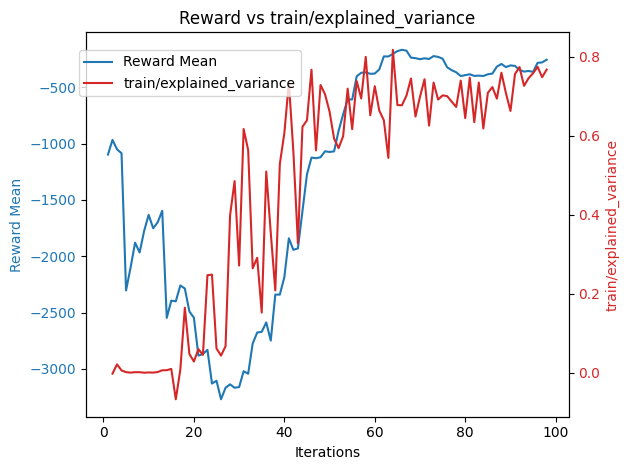

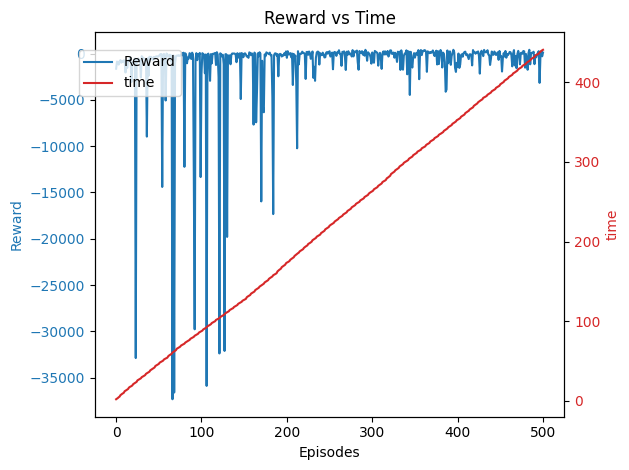

In [6]:
train_data_log: DataFrame = pd.read_csv(tmp_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(tmp_path+"monitor.csv", header=1)

# train_data_monitor = pd.concat([train_data_monitor] * 3, ignore_index=True)
print(train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = 'tab:blue'
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [25]:
seed = None
env = make(env_id, seed=seed)
model = PPO.load(name, print_system_info=True)
print(type(env))
num_steps = 1
obs, _ = env.reset()
# Variables de información:
acciones = []
rewards = []
ocu = []
tams = []
num = []
lim_ocu = 0
a2 = []

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        if len(ant) > 0 and ant != info:
            print(info["Stats"])
        ant = info

        ocu.append(info["Stats"]["OcupacionActual"])
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])

        rewards.append(reward)
        acciones.append(action.item())

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1

# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x, 0)), rewards)))
print(a2)
print(acciones.count(acciones[-1])/len(acciones))

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

<class 'custom_env.router_env.RouterEnv'>
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.0, 'Descartados': 0}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 11, 'TamañoTotal': 8266.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.044, 'Descartados': 0}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 21, 'TamañoTotal': 14028.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.084, 'Descartados': 0}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 30, 'TamañoTotal': 19584

In [26]:
assert len(acciones) != a2.count(
    Acciones.DENEGAR), "Se han denegado todos los paquetes"
assert len(acciones) != a2.count(
    Acciones.PERMITIR), "Se han permitido todos los paquetes"

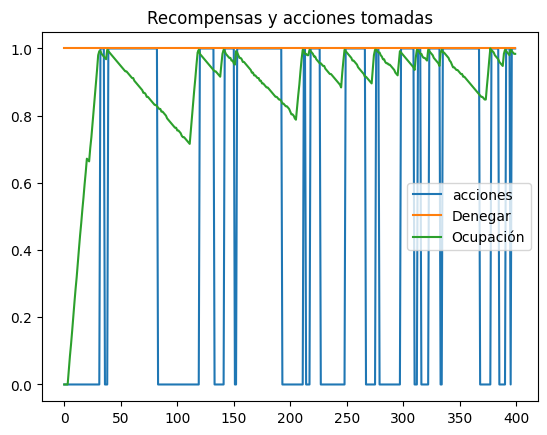

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -72.0, -10.0, -11.0, -11.0, 1.0, 1.0, 1.0, -8.0, -11.0, -11.0, -11.0, -11.0, -11.0, -10.0, -11.0, -10.0, -10.0, -11.0, -10.0, -11.0, -10.0, -10.0, -11.0, -10.0, -11.0, -11.0, -10.0, -10.0, -10.0, -11.0, -10.0, -10.0, -11.0, -10.0, -10.0, -11.0, -11.0, -11.0, -11.0, -10.0, -10.0, -11.0, -10.0, -11.0, -10.0, -10.0, -11.0, -10.0, -11.0, -11.0, -10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -128.0, -10.0, -10.0, -11.0, -11.0, -11.0, -10.0, -10.0, -11.0, -10.0, -10.0, -10.0, -11.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -72.0, -10.0, -11.0, -10.0, -11.0, -11.0, -10.0, -11.0, -11.0, 1.0, 1.0, 1.0, -11.0, -11.0, -11.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -11.0, -11.0, 

In [27]:
assert len(acciones) == len(rewards)
# plt.plot(rewards, label="rewards")
plt.plot(acciones, label="acciones")

plt.plot([Acciones.action_to_int(Acciones.DENEGAR)]
         * len(acciones), label="Denegar")
plt.plot(ocu, label="Ocupación")
plt.title("Recompensas y acciones tomadas")

plt.legend()
plt.show()
print("Rewards: ", rewards)
num_permitidos = acciones.count(Acciones.action_to_int(Acciones.PERMITIR))
print(num_permitidos, len(acciones)-num_permitidos, "",
      num_permitidos/len(acciones), 1-num_permitidos/len(acciones))

Ocupación:  [0.0, 0.0, 0.0, 0.0, 0.044, 0.084, 0.12, 0.16, 0.204, 0.244, 0.284, 0.32, 0.364, 0.404, 0.444, 0.48, 0.52, 0.556, 0.596, 0.632, 0.672, 0.668, 0.664, 0.704, 0.736, 0.776, 0.816, 0.856, 0.896, 0.936, 0.98, 0.992, 0.992, 0.984, 0.98, 0.976, 0.972, 0.968, 0.996, 0.992, 0.988, 0.984, 0.98, 0.976, 0.972, 0.968, 0.964, 0.96, 0.956, 0.952, 0.948, 0.944, 0.94, 0.936, 0.932, 0.932, 0.928, 0.924, 0.92, 0.916, 0.912, 0.912, 0.904, 0.9, 0.896, 0.892, 0.888, 0.884, 0.88, 0.876, 0.868, 0.868, 0.864, 0.856, 0.856, 0.852, 0.848, 0.844, 0.84, 0.836, 0.832, 0.832, 0.828, 0.824, 0.82, 0.82, 0.812, 0.812, 0.808, 0.804, 0.8, 0.792, 0.788, 0.784, 0.78, 0.776, 0.772, 0.768, 0.764, 0.764, 0.756, 0.756, 0.752, 0.748, 0.74, 0.736, 0.736, 0.732, 0.728, 0.724, 0.72, 0.716, 0.756, 0.796, 0.836, 0.876, 0.912, 0.952, 0.988, 0.996, 0.984, 0.98, 0.976, 0.972, 0.968, 0.964, 0.96, 0.956, 0.952, 0.948, 0.944, 0.94, 0.936, 0.932, 0.932, 0.928, 0.924, 0.92, 0.916, 0.952, 0.984, 0.996, 0.992, 0.984, 0.98, 0.976, 

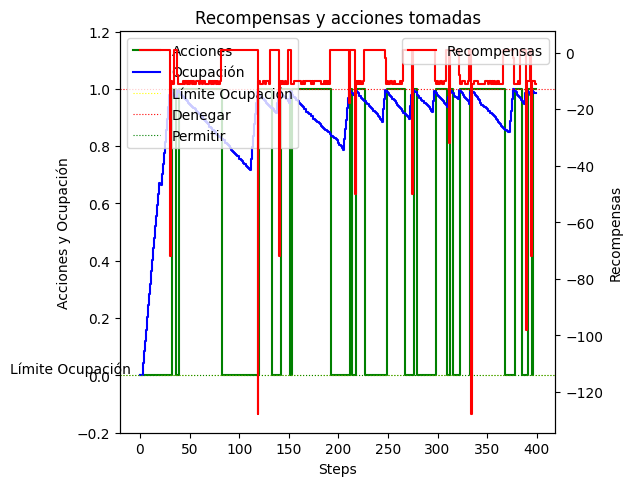

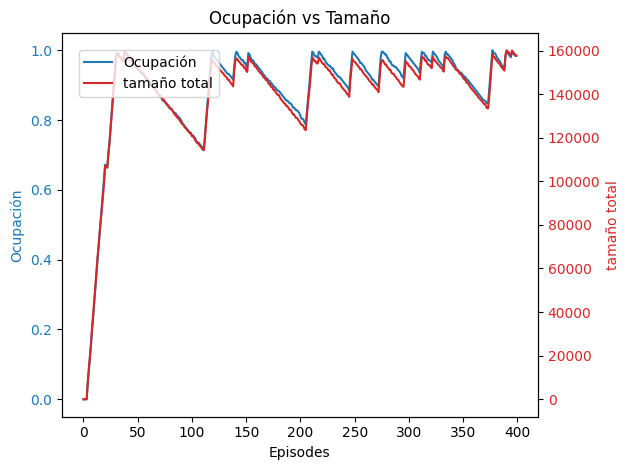

La ocupación máxima es de 100%
La ocupación mínima es de 0%


In [28]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post',color='green')
# ax1.step(range(len(acciones)), [1] * len(acciones), label="Denegar", where='mid')  # Ajustar según tus datos
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid', color='blue')

# Crear línea horizontal en el gráfico
ax1.axhline(y=lim_ocu, color='yellow', linestyle='dotted',
            linewidth=0.8, label='Límite Ocupación')

# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales
if lim_ocu not in ticks:
    ticks.append(lim_ocu)  # Agregar el límite de ocupación a los ticks
ax1.set_yticks(sorted(ticks))  # Actualizar los ticks

# Anotar el límite en el eje
ax1.annotate(
    'Límite Ocupación',
    xy=(-0.1, lim_ocu),  # Coordenada en el eje Y
    xytext=(-50, lim_ocu + 5),
    textcoords='offset points',
    fontsize=10, color='black',
    ha='center',
    va='center'
)
ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x/1 for x in tams]


"""
plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.plot([lim_ocu]*len(ocu), label="LimiteOcupación")
"""

fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = 'tab:red'
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tams)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

"""plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')


plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()"""
print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")

## Pruebas:


In [29]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones) > 1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


In [30]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1


['EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'Estado

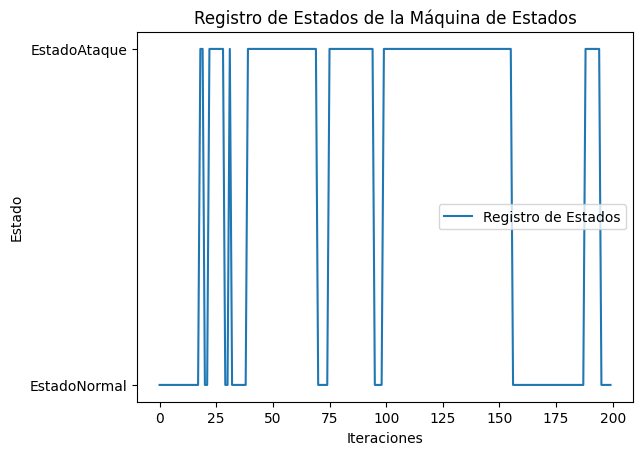

In [31]:
from custom_env.states import *
maquina = MaquinaDeEstados()
for _ in range(200):
    maquina.cambiar_estado()
print(maquina.registro_estados)

plt.plot(maquina.registro_estados, label="Registro de Estados")
plt.xlabel("Iteraciones")
plt.ylabel("Estado")
plt.title("Registro de Estados de la Máquina de Estados")
plt.legend()
plt.show()

In [32]:
# Lista de ejemplo
lista: list[str] = [x.__name__ for x in maquina.estados_posibles]
combinaciones_con_repeticion = list(product(lista, repeat=2))
dict_con: dict[tuple[str, str], int] = {
    x: 0 for x in combinaciones_con_repeticion}

print(dict_con)
duracion_ataques = []
estado_Ant = maquina.registro_estados[0]

for estado in maquina.registro_estados[1:]:
    dict_con[(estado_Ant, estado)] += 1

    if (estado_Ant, estado) == (EstadoNormal.__name__, EstadoAtaque.__name__):  # Empieza ataque
        duracion_ataques.append(1)
    elif (estado_Ant, estado) == (EstadoAtaque.__name__, EstadoAtaque.__name__):  # Sigue ataque
        if len(duracion_ataques) > 0:
            duracion_ataques[-1] += 1

    estado_Ant: Estado = estado

print(
    f"Como promedio los {len(duracion_ataques)} ataques duran {np.mean(duracion_ataques):.1f} iteraciones.")
print("Duracion 5 primeros ataques: ", duracion_ataques[:5], "...")
try:
    for estado1 in lista:
        total = 0
        for estado2 in lista:
            total += dict_con[(estado1, estado2)]
        print(f"Estando en {estado1}:")
        for estado2 in lista:
            print(f"De {estado1} a {estado2}: {
                dict_con[(estado1, estado2)] / total:6.2%}")
except:
    pass

{('EstadoNormal', 'EstadoNormal'): 0, ('EstadoNormal', 'EstadoAtaque'): 0, ('EstadoAtaque', 'EstadoNormal'): 0, ('EstadoAtaque', 'EstadoAtaque'): 0}
Como promedio los 7 ataques duran 17.9 iteraciones.
Duracion 5 primeros ataques:  [2, 7, 1, 31, 20] ...
Estando en EstadoNormal:
De EstadoNormal a EstadoNormal: 90.54%
De EstadoNormal a EstadoAtaque:  9.46%
Estando en EstadoAtaque:
De EstadoAtaque a EstadoNormal:  5.60%
De EstadoAtaque a EstadoAtaque: 94.40%


In [33]:
_np_random, _ = seeding.np_random(None)
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=True))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=False))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
print(type(0.0), type(0))
print(int(0.2))

1,10,5,3
1,9,5,3
<class 'float'> <class 'int'>
0
